# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS
import os
import csv
import math
import random
import time
import os.path as path
from datetime import datetime

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from tensorflow.contrib.learn import monitors
from tensorflow.contrib.metrics import streaming_accuracy, streaming_precision, streaming_recall
from pandas_ml.confusion_matrix import ConfusionMatrix as ConfusionMatrix_pandas

# Visualizations will be shown in the notebook.
%matplotlib inline 

repeat=0 # Binary check to see if an augmented dataset needs to be recreated [0- skip augmentation, 1- augment data].

---
## Step 1: Load Datasets

In [2]:
## LOAD PICKLED DATASET & SPLIT DATA

t0=time.clock() # Obtain run-times.
print("Obtaining datasets.")
# Training, Validation, and Testing data.
training_file='traffic-signs-data/train.p' 
validation_file='traffic-signs-data/valid.p'
testing_file='traffic-signs-data/test.p'
augment_file='traffic-signs-data/augmented_train.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


print("Ensuring equal lengths for features and labels.")
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))

# Dataset labels in the German traffic sign dataset.
label_legend='signnames.csv'
arr_classes=pd.read_csv(label_legend,index_col=None).values
arr_classes=arr_classes[:,1]
print("All datasets loaded.")

Obtaining datasets.
Ensuring equal lengths for features and labels.
All datasets loaded.


---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
## BASIC UNDERSTANDING OF DATASET

# Number of training examples.
n_train = X_train.shape[0]

# Number of validation examples.
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# Shape of an traffic sign image.
image_shape = X_train[1].shape

# Unique classes/labels in the dataset.
n_classes = len(np.unique(y_train))

# Further manipulation.
total_sets=n_train+n_validation+n_test
frac_train=n_train/total_sets
frac_valid=n_validation/total_sets
frac_test=n_test/total_sets

class_list,class_indices,class_counts=np.unique(y_train, return_index=True, return_counts=True)

print("Class indices", class_indices)
print("Class counts", class_counts)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("There are",total_sets, "datasets, split",round(frac_train,2),"-",\
      round(frac_valid,2),"-",round(frac_test,2),"training, validation, and testing respectively.")
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Class indices [ 9960  2220 31439  5370  6810 12360 21450 23730 15870 11040 17130  8580
 27329 21810 29219 29909  5010 30449 20370  6630 25950 25680  4500  1770
 10800 33449  1230 10350 26849 10560 25020   210 10140 26250 20010 18930
   900  4830 14010 25410  4200     0  9750]
Class counts [ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920  690
  540  360  990 1080  180  300  270  330  450  240 1350  540  210  480  240
  390  690  210  599  360 1080  330  180 1860  270  300  210  210]
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
There are 51839 datasets, split 0.67 - 0.09 - 0.24 training, validation, and testing respectively.
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

#### Visualizing sample training set images

Class 0 Speed limit (20km/h) : 180 samples.


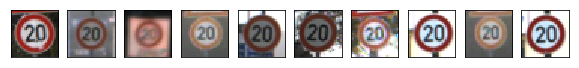

Class 1 Speed limit (30km/h) : 1980 samples.


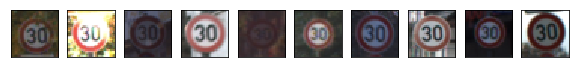

Class 2 Speed limit (50km/h) : 2010 samples.


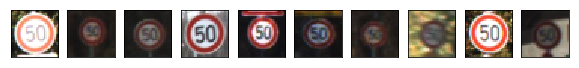

Class 3 Speed limit (60km/h) : 1260 samples.


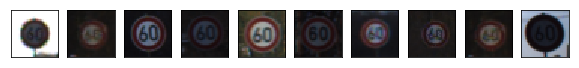

Class 4 Speed limit (70km/h) : 1770 samples.


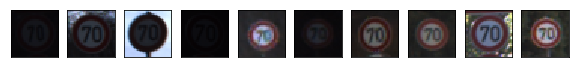

Class 5 Speed limit (80km/h) : 1650 samples.


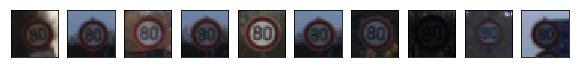

Class 6 End of speed limit (80km/h) : 360 samples.


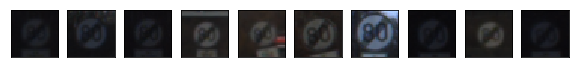

Class 7 Speed limit (100km/h) : 1290 samples.


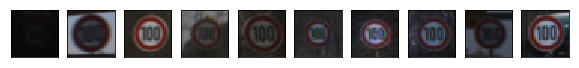

Class 8 Speed limit (120km/h) : 1260 samples.


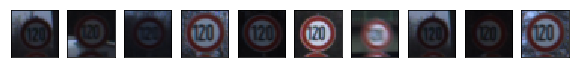

Class 9 No passing : 1320 samples.


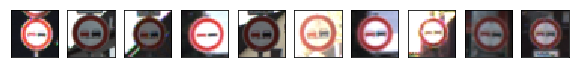

Class 10 No passing for vehicles over 3.5 metric tons : 1800 samples.


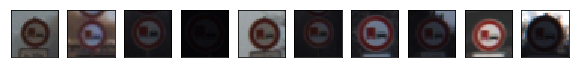

Class 11 Right-of-way at the next intersection : 1170 samples.


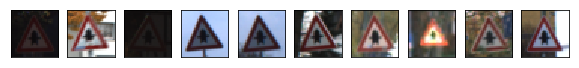

Class 12 Priority road : 1890 samples.


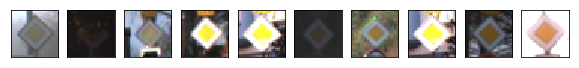

Class 13 Yield : 1920 samples.


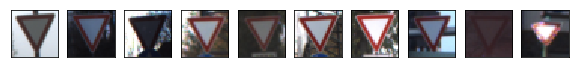

Class 14 Stop : 690 samples.


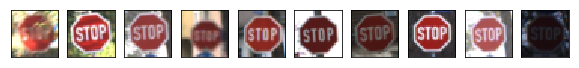

Class 15 No vehicles : 540 samples.


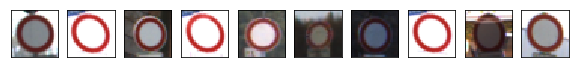

Class 16 Vehicles over 3.5 metric tons prohibited : 360 samples.


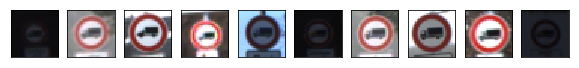

Class 17 No entry : 990 samples.


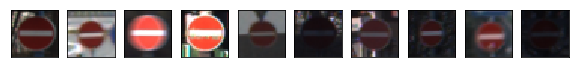

Class 18 General caution : 1080 samples.


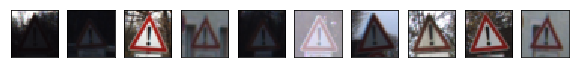

Class 19 Dangerous curve to the left : 180 samples.


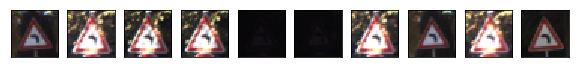

Class 20 Dangerous curve to the right : 300 samples.


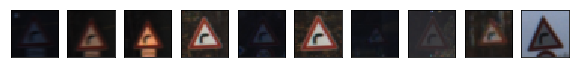

Class 21 Double curve : 270 samples.


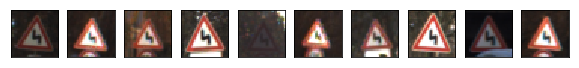

Class 22 Bumpy road : 330 samples.


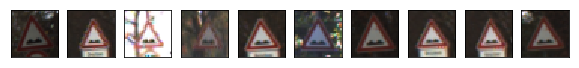

Class 23 Slippery road : 450 samples.


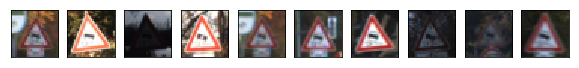

Class 24 Road narrows on the right : 240 samples.


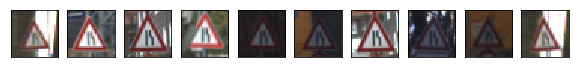

Class 25 Road work : 1350 samples.


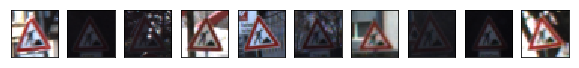

Class 26 Traffic signals : 540 samples.


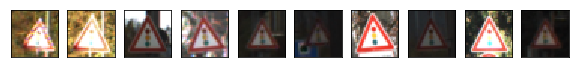

Class 27 Pedestrians : 210 samples.


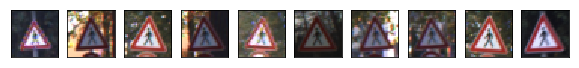

Class 28 Children crossing : 480 samples.


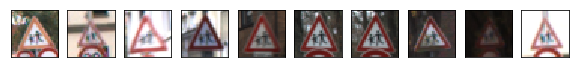

Class 29 Bicycles crossing : 240 samples.


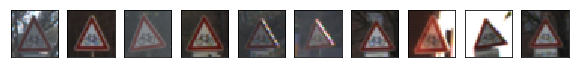

Class 30 Beware of ice/snow : 390 samples.


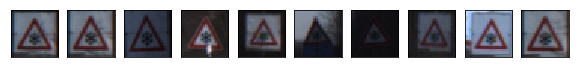

Class 31 Wild animals crossing : 690 samples.


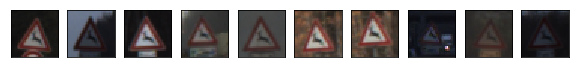

Class 32 End of all speed and passing limits : 210 samples.


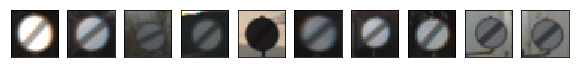

Class 33 Turn right ahead : 599 samples.


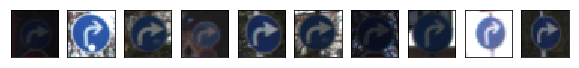

Class 34 Turn left ahead : 360 samples.


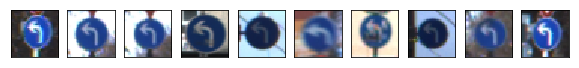

Class 35 Ahead only : 1080 samples.


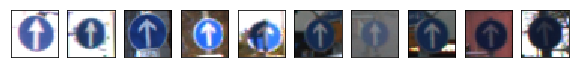

Class 36 Go straight or right : 330 samples.


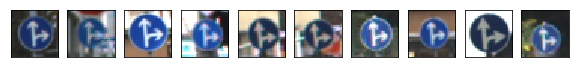

Class 37 Go straight or left : 180 samples.


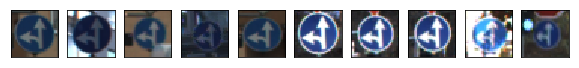

Class 38 Keep right : 1860 samples.


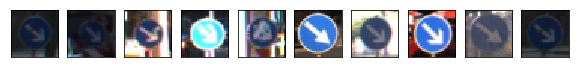

Class 39 Keep left : 270 samples.


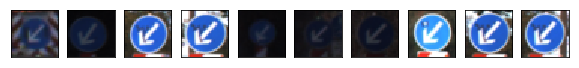

Class 40 Roundabout mandatory : 300 samples.


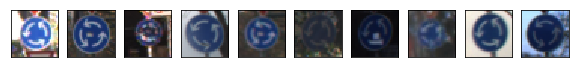

Class 41 End of no passing : 210 samples.


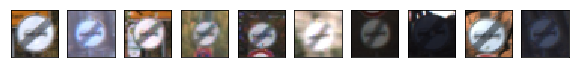

Class 42 End of no passing by vehicles over 3.5 metric tons : 210 samples.


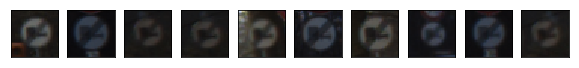

In [4]:
## DATA EXPLORATION & VISUALIZATION

# Plot traffic sign images.
for Class,Index,Counts in zip(class_list,class_indices,class_counts):
    print("Class {} {} : {} samples.".format(Class,arr_classes[Class],Counts))
    Main=plt.figure(figsize=(10,5))
    choice=random.sample(range(Index,Counts+Index),10)
    for i in range (0,10):
        row=Main.add_subplot(1,10,i+1,xticks=[],yticks=[])
        row.imshow(X_train[choice[i]])
    plt.show()

#### Training and Testing set representations

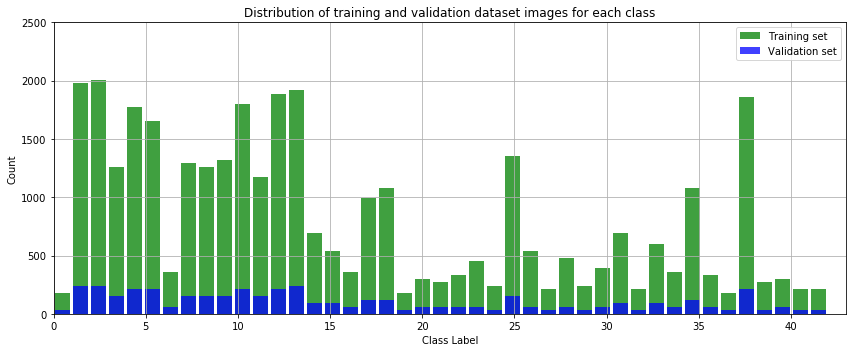

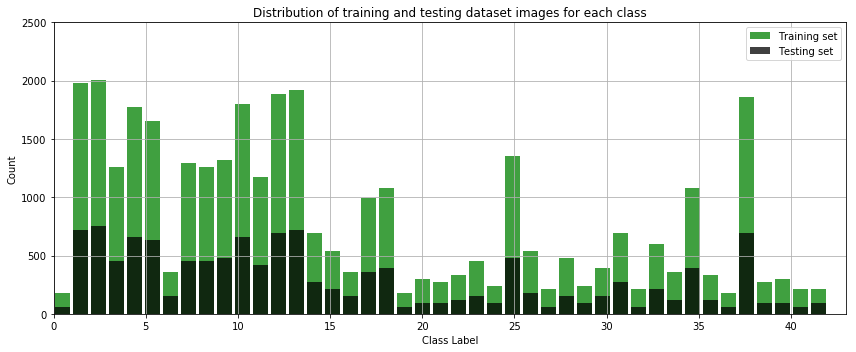

In [5]:
## DATA EXPLORATION & VISUALIZATION

# Histogram plot to identify count of each class.
hist_ytrain_count=np.bincount(y_train)
hist_xtrain_count=len(hist_ytrain_count)

plt.figure(figsize=(12,5))
plt.hist(y_train, hist_xtrain_count, normed=False, facecolor='green',align='mid',rwidth=0.8,alpha=0.75,label='Training set')
plt.hist(y_valid,hist_xtrain_count, normed=False, facecolor='blue',align='mid',rwidth=0.8, alpha=0.75, label='Validation set')
plt.legend(loc='upper right')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(r'Distribution of training and validation dataset images for each class')
plt.axis([0, 43,0,2500])
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plt.hist(y_train, hist_xtrain_count, normed=False, facecolor='green',align='mid',rwidth=0.8,alpha=0.75,label='Training set')
plt.hist(y_test,hist_xtrain_count, normed=False, facecolor='black',align='mid',rwidth=0.8, alpha=0.75, label='Testing set')
plt.legend(loc='upper right')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(r'Distribution of training and testing dataset images for each class')
plt.axis([0, 43,0,2500])
plt.grid(True)
plt.tight_layout()
plt.show()

----

## Step 3: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Augment the Dataset

In [6]:
max_bincount=max(class_counts)
min_bincount=min(class_counts)
print("This step tries to smooth out possible wrong classifications and bias due to varying class lengths as the maximum class size is {} and the minimum is {}.".format(max_bincount,min_bincount))

This step tries to smooth out possible wrong classifications and bias due to varying class lengths as the maximum class size is 2010 and the minimum is 180.


### Preprocess the Dataset

The dataset is preprocessed by gray-scale conversion followed by normalizing to have zero mean and equal variance:'(pixel - 128)/ 128', then shuffling the datasets.


In [7]:
## DATA PRE-PROCESS FUNCTIONS
# if (path.exists(augment_file) and repeat==0):
#     print("Preprocessing skipped as the augmented pickle already exists.") 
#     pass
# else:
def grayscale(raw_image): # Convert to grayscale
    return cv2.cvtColor(raw_image,cv2.COLOR_BGR2GRAY)

def normalize(raw_image): # Min-Max normalization
    min_pixel=np.min(raw_image)
    max_pixel=np.max(raw_image)
    return ((raw_image-min_pixel)/(max_pixel-min_pixel))

def equalize(raw_image): # Adaptive Histogram equalization
    clahe=cv2.createCLAHE()
    return clahe.apply(raw_image)

def randomize(dataset,labels):
    permutation=np.random.permutation(labels.shape[0])
    shuffled_dataset=dataset[permutation,:,:]
    shuffled_labels=labels[permutation,:,:]
    return (shuffled_dataset,shuffled_labels)    

In [8]:
if (path.exists(augment_file) and repeat==0):
    print("Preprocessing skipped as the augmented pickle already exists.")
    X_valid_normalized=[]
    X_test_normalized=[]

    
    for image in X_valid:
        valid_image_grayscale=(grayscale(image))
        X_valid_normalized.append(normalize(valid_image_grayscale))

    for image in X_test:
        test_image_grayscale=(grayscale(image))
        X_test_normalized.append(normalize(test_image_grayscale))
    
    X_valid_normalized=np.asarray(X_valid_normalized)
    X_test_normalized=np.asarray(X_test_normalized)
    
    pass
else:
    print("Preprocessing started.")

    X_train_normalized=[]
    X_valid_normalized=[]
    X_test_normalized=[]

    for image in X_train:
        train_image_grayscale=(grayscale(image))
        X_train_normalized.append(normalize(train_image_grayscale))
    
    for image in X_valid:
        valid_image_grayscale=(grayscale(image))
        X_valid_normalized.append(normalize(valid_image_grayscale))

    for image in X_test:
        test_image_grayscale=(grayscale(image))
        X_test_normalized.append(normalize(test_image_grayscale))
        
    X_train_normalized=np.asarray(X_train_normalized)
    X_valid_normalized=np.asarray(X_valid_normalized)
    X_test_normalized=np.asarray(X_test_normalized)
    
    print("Preprocessing: Grayscaling, Histogram Equalization, and Normalizing complete.")

Preprocessing skipped as the augmented pickle already exists.


### Augment the Dataset

Increasing class sizes and images for each class in the training set by various image manipulations. Also aims to obtain a balanced representation of classes.

In [9]:
## IMAGE MANIPULATION FUNCTIONS

if (path.exists(augment_file) and repeat==0):
    print("Preprocessing skipped as the augmented pickle already exists.") 
    pass
else:

    def rotation(raw_image,angle_range):
        theta_rot=np.random.uniform(angle_range)-0.5*angle_range
        rows,cols=raw_image.shape
        rot_M=cv2.getRotationMatrix2D((cols/2,rows/2),theta_rot,1)
        return cv2.warpAffine(raw_image,rot_M,(cols,rows))

    def translation(raw_image,translation_range):
        rows,cols=raw_image.shape
        trans_x=translation_range*np.random.uniform()-0.5*translation_range
        trans_y=translation_range*np.random.uniform()-0.5*translation_range
        trans_M=np.float32([[1,0,trans_x],[0,1,trans_y]])
        return cv2.warpAffine(raw_image,trans_M,(cols,rows))

    def shear(raw_image):
        rows,cols=raw_image.shape
        x1=0.2*cols;y1=0.2*rows
        x2=0.8*cols;y2=0.8*rows
        mult_x=(np.random.random(3)-0.5)*cols*(0.05)
        mult_y=(np.random.random(3)-0.5)*rows*(0.05)

        points_1=np.float32([[y1,x1],
                            [y2,x1],
                            [y1,x2]])

        points_2=np.float32([[y1+mult_y[0],x1+mult_x[0]],
                            [y2+mult_y[1],x1+mult_x[1]],
                            [y1+mult_y[2],x2+mult_x[2]]])

        shear_M=cv2.getAffineTransform(points_1,points_2)
        return cv2.warpAffine(raw_image,shear_M,(cols,rows))

    def scale(raw_image):
        rows,cols=raw_image.shape
        scale_factor=np.random.uniform(0.5,5.0)
        return cv2.resize(raw_image,dsize=(32,32),fx=scale_factor,fy=scale_factor,interpolation=cv2.INTER_CUBIC)

    # def contrast(raw_image): # Removed because we are now working with a 1-channel image
    #     rows,cols=raw_image.shape
    #     hsv=cv2.cvtColor(raw_image,cv2.COLOR_BGR2HSV)
    #     h_channel,s_channel,v_channel=cv2.split(hsv)
    #     h_channel=np.add(h_channel,random.uniform(-100,100))
    #     v_channel=np.add(v_channel,random.uniform(-100,100))
    #     merged=np.uint8(np.dstack((h_channel,s_channel,v_channel)))
    #     return cv2.cvtColor(merged,cv2.COLOR_HSV2BGR)

    def flip_secondary(X,Y):
        X_flip_out=np.empty([0,32,32])
        y_flip_out=np.empty([0])
        
        label_flip_vertical=np.array([9,10,11,12,13,15,17,18,21,22,23,25,26,\
                                    27,28,29,30,31,32,35,40,41,42])
        label_flip_horizontal=np.array([1,5,7,9,10,12,15,17,32,38,39,40,41,42])
        label_flip_classes=np.array([[19,20],
                                    [20,19],
                                    [33,34],
                                    [34,33],
                                    [36,37],
                                    [37,36],
                                    [38,39],
                                    [39,38]]) #Source label (original label), target/goal label
        for class_label in range(n_classes):
            
            X_flip_out=np.append(X_flip_out,X[Y==class_label],axis=0)
 
            # Vertical Flip
            if class_label in label_flip_vertical:
                X_flip_out=np.append(X_flip_out,cv2.flip(X[Y==class_label],flipCode=0),axis=0)
            
            extended_length=len(X_flip_out)-len(y_flip_out)
            y_flip_out=np.append(y_flip_out,np.full((extended_length),class_label))
            
            # Horizontal Flip
            if class_label in label_flip_horizontal:
                X_flip_out=np.append(X_flip_out,cv2.flip(X[Y==class_label],flipCode=1),axis=0)
           
            extended_length=len(X_flip_out)-len(y_flip_out)
            y_flip_out=np.append(y_flip_out,np.full((extended_length),class_label))

            # Switch classes and vertical flip
            if class_label in label_flip_classes[:,0]:
                target_class=label_flip_classes[label_flip_classes[:,0]==class_label][0,1]
                target_images_flipped=X[Y==target_class][:,:,::-1]
                X_flip_out=np.append(X_flip_out,target_images_flipped,axis=0)

            extended_length=len(X_flip_out)-len(y_flip_out)
            y_flip_out=np.append(y_flip_out,np.full((extended_length),class_label))

        print("Augmenting images by flipping has been completed.")
        return (X_flip_out,y_flip_out)


Preprocessing skipped as the augmented pickle already exists.


In [10]:
if (path.exists(augment_file) and repeat==0):
    print("Preprocessing skipped as the augmented pickle already exists.") 
    pass
else:
    (X_existing_flipped,y_existing_flipped)=flip_secondary(X_train_normalized,y_train)
   
    print("Flipping augments data from {} entries to {} entries.".format(len(X_train_normalized),len(X_existing_flipped)))
    print("Flipped images array shape:", X_existing_flipped.shape)
    print("Flip complete.")

Preprocessing skipped as the augmented pickle already exists.


In [11]:
if (path.exists(augment_file) and repeat==0):
    print("Preprocessing skipped as the augmented pickle already exists.") 
    pass
else:
    indices_augmented=[]
    X_train_augmented=np.copy(X_existing_flipped)
    y_train_augmented=np.copy(y_existing_flipped)

    balance_threshold=900
    for class_index in range(0,n_classes):
        print("Current image placeholder {}".format(class_index))
        image_index=np.where(y_train==class_index)
        class_size=(np.size(image_index))

        repeat=balance_threshold-class_size
        if class_size<=balance_threshold:
            for i in range(0,repeat):
                if (i%100==0):
                    print("Class Label ", class_index,"--> Class Image Index",i)
                indices_augmented.append(X_train_augmented.shape[0])
                augment_raw_copy=X_train_normalized[image_index[0][i%class_size]]
                a0=rotation(augment_raw_copy,40)
                a1=translation(augment_raw_copy,10)
                a2=shear(augment_raw_copy)
                a3=scale(augment_raw_copy)
                
                X_train_augmented=np.concatenate((X_train_augmented,[a0,a1,a2,a3]),axis=0)
                y_train_augmented=np.concatenate((y_train_augmented,[class_index,class_index,class_index,class_index]),axis=0)

    print("Complete augmenting has been done by linear transform (rotation, translation, shear, scale).")
    

Preprocessing skipped as the augmented pickle already exists.


In [12]:
## PICKLING AUGMENTED DATASET
if (path.exists(augment_file) and repeat==0):
    print("Augmented pickle file already exists, skipping...")
    pass
else:
    augmented_pickle='traffic-signs-data/augmented_train.p'

    try:
        print("Pickling dataset.")
        pickled=open(augmented_pickle,'wb')
        save = {
        'augmented_train_dataset': X_train_augmented,
        'augmented_train_labels': y_train_augmented,
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Dataset pickled.")
    except:
        print("Error in creating a pickled dataset. Debug.")
    
#     del X_train_augmented
#     del y_train_augmented
#     del X_existing_flipped
#     del y_existing_flipped

Augmented pickle file already exists, skipping...


In [13]:
augment_file='traffic-signs-data/augmented_train.p'

with open(augment_file, mode='rb') as f:
    augment_train = pickle.load(f)

X_train_augmented, y_train_augmented = augment_train['augmented_train_dataset'], augment_train['augmented_train_labels']
print("Using {} dataset.".format(augment_file.split('/')[1]))
print("Shape of augmented features (X_train): ",X_train_augmented.shape)
print("Shape of augmented labels (y_train): ",y_train_augmented.shape)

print("Loaded augmented pickled file.")

Using augmented_train.p dataset.
Shape of augmented features (X_train):  (128192, 32, 32)
Shape of augmented labels (y_train):  (128192,)
Loaded augmented pickled file.


Visualizing augmented dataset.


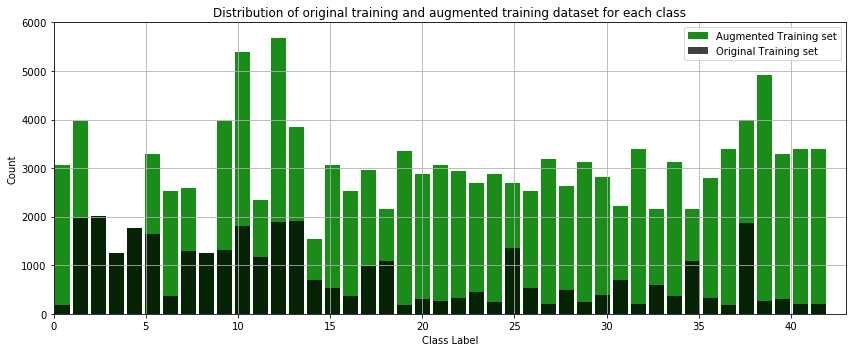

In [14]:
## DATA EXPLORATION & VISUALIZATION
print("Visualizing augmented dataset.")
# Histogram plot to identify count of each class.
hist_ytrain_count=np.bincount(y_train)
hist_xtrain_count=len(hist_ytrain_count)

plt.figure(figsize=(12,5))
plt.hist(y_train_augmented, hist_xtrain_count, normed=False, facecolor='green',align='mid',rwidth=0.8,alpha=0.9,label='Augmented Training set')
plt.hist(y_train,hist_xtrain_count, normed=False, facecolor='black',align='mid',rwidth=0.8, alpha=0.75, label='Original Training set')
plt.legend(loc='upper right')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title(r'Distribution of original training and augmented training dataset for each class')
plt.axis([0, 43,0,6000])
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
print("Shuffling and reshaping datasets.")

X_train_shuffle,y_train_shuffle=shuffle(np.asarray(X_train_augmented).reshape(len(X_train_augmented),32,32,1),np.asarray(y_train_augmented).reshape(len(y_train_augmented),))
X_valid_shuffle,y_valid_shuffle=shuffle(np.asarray(X_valid_normalized).reshape(len(X_valid_normalized),32,32,1),np.asarray(y_valid).reshape(len(y_valid),))
X_test_shuffle,y_test_shuffle=shuffle(np.asarray(X_test_normalized).reshape(len(X_test_normalized),32,32,1),np.asarray(y_test).reshape(len(y_test),))

print("Shuffled training datasets shape: ",X_train_shuffle.shape,"& ",y_train_shuffle.shape)
print("Shuffled validation datasets shape: ",X_valid_shuffle.shape,"& ",y_valid_shuffle.shape)
print("Shuffled testing datasets shape: ",X_test_shuffle.shape,"& ",y_test_shuffle.shape)

print("Datasets ready for pruning.")

Shuffling and reshaping datasets.
Shuffled training datasets shape:  (128192, 32, 32, 1) &  (128192,)
Shuffled validation datasets shape:  (4410, 32, 32, 1) &  (4410,)
Shuffled testing datasets shape:  (12630, 32, 32, 1) &  (12630,)
Datasets ready for pruning.


In [16]:
print("Balancing dataset across classes.")

prune_size=2500

class_label,class_counts=np.unique(y_train_shuffle,return_index=False,return_counts=True)

X_train_balanced=np.empty([0,32,32,1])
y_train_balanced=np.empty([0])
for class_index in range(n_classes):

    temp=X_train_shuffle[y_train_shuffle==class_index]
    
    if class_counts[class_index]>=prune_size:
        X_train_balanced=np.append(X_train_balanced,temp[:prune_size],axis=0)
    else:
        accepted_prune_size=class_counts[class_index]
        X_train_balanced=np.append(X_train_balanced,temp[:accepted_prune_size],axis=0)
    extended_length=len(X_train_balanced)-len(y_train_balanced)
    y_train_balanced=np.append(y_train_balanced,np.full((extended_length),class_index))

print("Balanced Datasets ready for the neural network.")

Balancing dataset across classes.
Balanced Datasets ready for the neural network.


Sanity checks on new dataset.

X_train_balanced shape : (101373, 32, 32, 1)
y_train_balanced shape : (101373,)
Visualization of new dataset.
Class 0.0 Speed limit (20km/h) : 2500 samples.


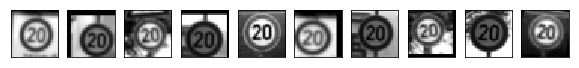

Class 1.0 Speed limit (30km/h) : 2500 samples.


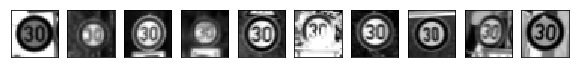

Class 2.0 Speed limit (50km/h) : 2010 samples.


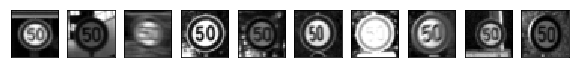

Class 3.0 Speed limit (60km/h) : 1260 samples.


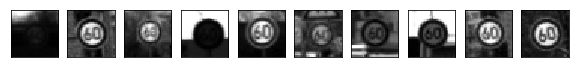

Class 4.0 Speed limit (70km/h) : 1770 samples.


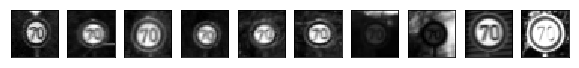

Class 5.0 Speed limit (80km/h) : 2500 samples.


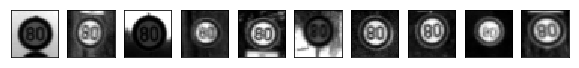

Class 6.0 End of speed limit (80km/h) : 2500 samples.


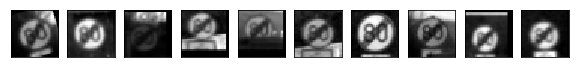

Class 7.0 Speed limit (100km/h) : 2500 samples.


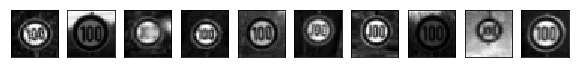

Class 8.0 Speed limit (120km/h) : 1260 samples.


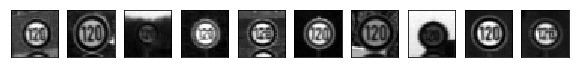

Class 9.0 No passing : 2500 samples.


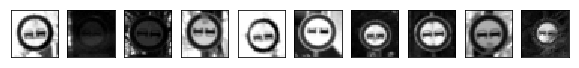

Class 10.0 No passing for vehicles over 3.5 metric tons : 2500 samples.


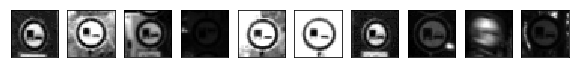

Class 11.0 Right-of-way at the next intersection : 2340 samples.


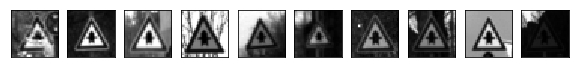

Class 12.0 Priority road : 2500 samples.


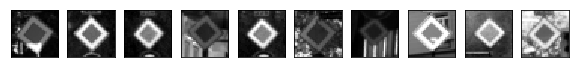

Class 13.0 Yield : 2500 samples.


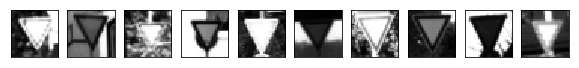

Class 14.0 Stop : 1530 samples.


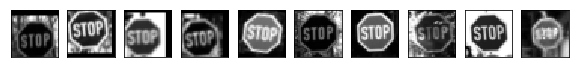

Class 15.0 No vehicles : 2500 samples.


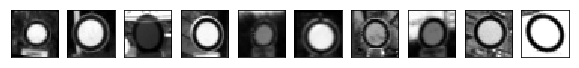

Class 16.0 Vehicles over 3.5 metric tons prohibited : 2500 samples.


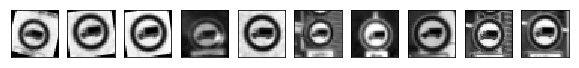

Class 17.0 No entry : 2500 samples.


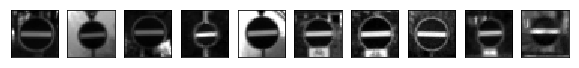

Class 18.0 General caution : 2160 samples.


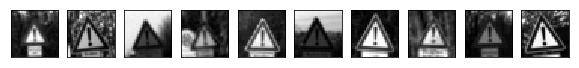

Class 19.0 Dangerous curve to the left : 2500 samples.


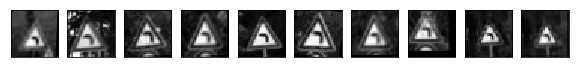

Class 20.0 Dangerous curve to the right : 2500 samples.


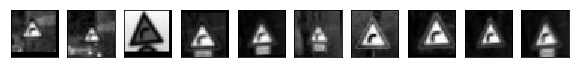

Class 21.0 Double curve : 2500 samples.


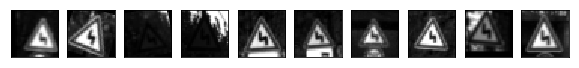

Class 22.0 Bumpy road : 2500 samples.


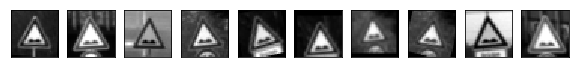

Class 23.0 Slippery road : 2500 samples.


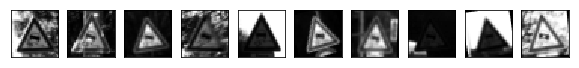

Class 24.0 Road narrows on the right : 2500 samples.


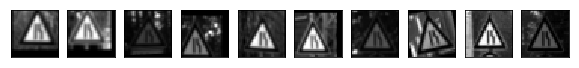

Class 25.0 Road work : 2500 samples.


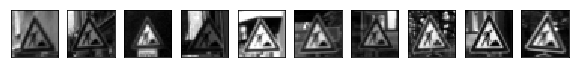

Class 26.0 Traffic signals : 2500 samples.


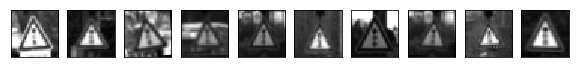

Class 27.0 Pedestrians : 2500 samples.


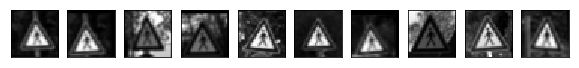

Class 28.0 Children crossing : 2500 samples.


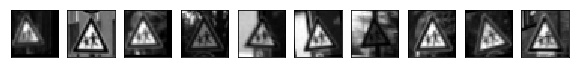

Class 29.0 Bicycles crossing : 2500 samples.


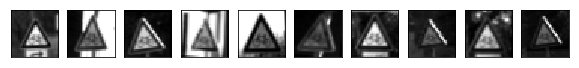

Class 30.0 Beware of ice/snow : 2500 samples.


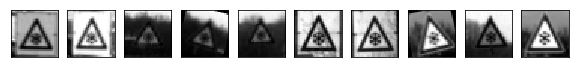

Class 31.0 Wild animals crossing : 2220 samples.


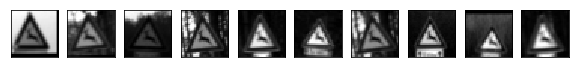

Class 32.0 End of all speed and passing limits : 2500 samples.


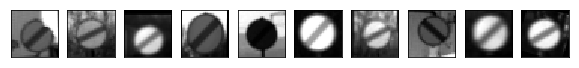

Class 33.0 Turn right ahead : 2163 samples.


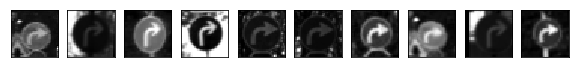

Class 34.0 Turn left ahead : 2500 samples.


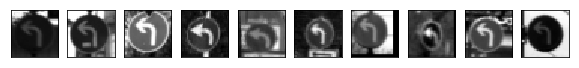

Class 35.0 Ahead only : 2160 samples.


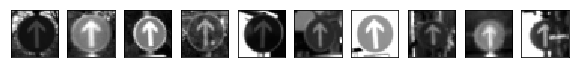

Class 36.0 Go straight or right : 2500 samples.


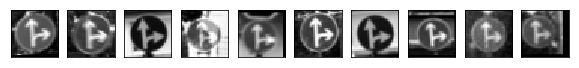

Class 37.0 Go straight or left : 2500 samples.


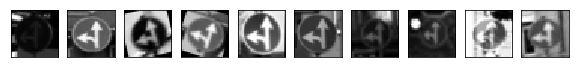

Class 38.0 Keep right : 2500 samples.


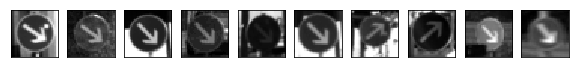

Class 39.0 Keep left : 2500 samples.


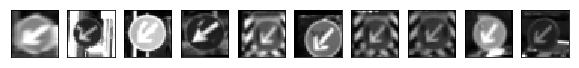

Class 40.0 Roundabout mandatory : 2500 samples.


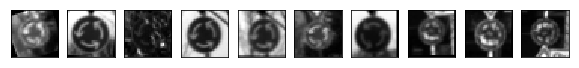

Class 41.0 End of no passing : 2500 samples.


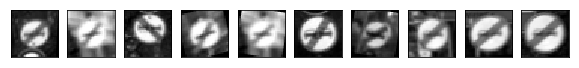

Class 42.0 End of no passing by vehicles over 3.5 metric tons : 2500 samples.


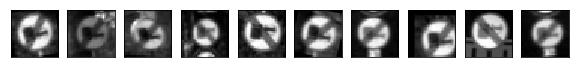

In [17]:
# Checking validity of final balanced dataset.
print("Sanity checks on new dataset.\n")

print("X_train_balanced shape :", X_train_balanced.shape)
print("y_train_balanced shape :", y_train_balanced.shape)

## DATA EXPLORATION & VISUALIZATION
print("Visualization of new dataset.")
X_train_temp_balanced=X_train_balanced.reshape(len(X_train_balanced),32,32)

new_class_list,new_class_indices,new_class_counts=np.unique(y_train_balanced, return_index=True, return_counts=True)

# Plot traffic sign images.
for newClass,newIndex,newCounts in zip(new_class_list,new_class_indices,new_class_counts):
    
    print("Class {} {} : {} samples.".format(newClass,arr_classes[int(newClass)],newCounts))
    Main2=plt.figure(figsize=(10,5))
    choice=random.sample(range(newIndex,newCounts+newIndex),10)
    for i in range (0,10):
        row=Main2.add_subplot(1,10,i+1,xticks=[],yticks=[])
        row.imshow(X_train_temp_balanced[choice[i]],cmap='gray')
    plt.show()
# del X_train_temp_balanced

In [18]:
# Checking validity of final balanced dataset.
print("Sanity checks on new dataset.\n")

print("Balanced dataset sizes :", new_class_counts,"\n")

print("Checking for duplicate images in train-validation-test datasets.")
balanced_train_dataset=X_train_balanced
valid_dataset=X_valid_shuffle
test_dataset=X_test_shuffle

balanced_train_dataset.flags.writeable=False
valid_dataset.flags.writeable=False
test_dataset.flags.writeable=False

train_hash=set([hash(image.tobytes()) for image in balanced_train_dataset])
valid_hash=set([hash(image.tobytes()) for image in valid_dataset])
test_hash=set([hash(image.tobytes()) for image in test_dataset])

train_duplicates=len(balanced_train_dataset)-len(train_hash)
overlap_train_valid=len(set.intersection(train_hash,valid_hash))
overlap_train_test=len(set.intersection(train_hash,test_hash))
overlap_valid_test=len(set.intersection(valid_hash,test_hash))

print("Training set overlap of {} duplicate images".format(train_duplicates))
print("Train-Valid Overlap of {} images".format(overlap_train_valid))
print("Train-Test Overlap of {} images".format(overlap_train_test))
print("Valid-Test Overlap of {} images".format(overlap_valid_test))

# del balanced_train_dataset
# del valid_dataset
# del test_dataset

Sanity checks on new dataset.

Balanced dataset sizes : [2500 2500 2010 1260 1770 2500 2500 2500 1260 2500 2500 2340 2500 2500 1530
 2500 2500 2500 2160 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2220 2500 2163 2500 2160 2500 2500 2500 2500 2500 2500 2500] 

Checking for duplicate images in train-validation-test datasets.
Training set overlap of 22564 duplicate images
Train-Valid Overlap of 0 images
Train-Test Overlap of 0 images
Valid-Test Overlap of 0 images


### Model Architecture- Setups

In [19]:
EPOCHS=75
BATCH_SIZE=100

# BASIC HYPERPARAMETERS
mu=0.0
sigma=0.1

In [20]:
# Defining commonly used tensorflow functions

def convolution(layer,kernel,bias):
    # W- Weight [Filter height, Filter width, color_channels, k_output]
    temp=tf.nn.conv2d(layer,kernel,strides=[1,1,1,1],padding='SAME')
    return tf.nn.bias_add(temp,bias)

def full_connected(layer,weight,bias):
    temp=tf.matmul(layer,weight)
    return tf.nn.bias_add(temp,bias)
    
def maxpool(layer):
    return tf.nn.max_pool(layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

def maxpool_3x3(layer):
    return tf.nn.max_pool(layer,ksize=[1,3,3,1],strides=[1,1,1,1],padding='SAME')
    
def relu(layer,name):
    return tf.nn.relu(layer,name=name)

def dropout(layer,keep_prob):
    return tf.nn.dropout(layer,keep_prob)

def evaluate(X_dataset,Y_dataset):
    total_accuracy=0
    data_size=len(X_dataset)
    
    sess=tf.get_default_session()
    for offset in range(0,data_size,BATCH_SIZE):
        batch_x,batch_y=X_dataset[offset:offset+BATCH_SIZE],Y_dataset[offset:offset+BATCH_SIZE]
        local_accuracy=sess.run(accuracy_operation,feed_dict={X:batch_x, Y:batch_y, keep_prob:1.0})
        total_accuracy+=(local_accuracy*len(batch_x))
    return total_accuracy/data_size

In [21]:
X=tf.placeholder(tf.float32,(None,32,32,1))
Y=tf.placeholder(tf.int32,(None))
keep_prob=tf.placeholder(tf.float32)
one_hot_y=tf.one_hot(Y,43)

### Architecture One: LeNet-5

#### Train, Validate and Test the Model: LeNet-5

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### Architecture Two: VGG-16

#### Train, Validate and Test the Model: VGG-16

### Architecture Three: Repurposed Barebones Model

#### Train, Validate and Test the Model: Barebones inception architecture

### Architecture Four: Simplified CNN Model

In [22]:
EPOCHS=75
BATCH_SIZE=64

# BASIC HYPERPARAMETERS
mu=0.0
sigma=0.1
# MISC
save_path='./tf-sessions-data/simplecnn_m2_e75_lr100'

In [23]:
sess=tf.InteractiveSession()

In [24]:
def Simple_CNN(x):
#     with tf.variable_scope("param"):
    weights={
        'W_conv1': tf.Variable(tf.truncated_normal(shape=(5,5,1,16), mean=mu, stddev=sigma), name='W_conv1'),
        'W_conv2': tf.Variable(tf.truncated_normal(shape=(3,3,16,32), mean=mu, stddev=sigma), name='W_conv2'),
        'W_conv3': tf.Variable(tf.truncated_normal(shape=(3,3,32,64), mean=mu, stddev=sigma), name='W_conv2'),
        
        'W_dense1': tf.Variable(tf.truncated_normal(shape=(1024,1024), mean=mu, stddev=sigma), name='W_dense1'),
        'W_dense2': tf.Variable(tf.truncated_normal(shape=(1024,512), mean=mu, stddev=sigma), name='W_dense2'),
        'W_dense3': tf.Variable(tf.truncated_normal(shape=(512,256), mean=mu, stddev=sigma), name='W_dense3'),
        'W_output': tf.Variable(tf.truncated_normal(shape=(256,43), mean=mu, stddev=sigma), name='W_output') 
    }
    
    biases={
        'b_conv1': tf.Variable(tf.truncated_normal([16])),
        'b_conv2': tf.Variable(tf.truncated_normal([32])),
        'b_conv3': tf.Variable(tf.truncated_normal([64])),
       
        'b_dense1': tf.Variable(tf.truncated_normal([1024])),
        'b_dense2': tf.Variable(tf.truncated_normal([512])),
        'b_dense3': tf.Variable(tf.truncated_normal([256])),
        'b_output': tf.Variable(tf.truncated_normal([43]))
    }
    
    # Layer One: Convolution
    with tf.name_scope("Convolution_Layer_1") as scope:
        conv1=convolution(x,weights['W_conv1'],biases['b_conv1'])
        # Layer One: Activation
        conv1=relu(conv1,'activation_1')
    # Layer One: Max-Pooling
    with tf.name_scope("MaxPool_1") as scope:
        pool1=maxpool(conv1)
        
    # Layer Two: Convolution
    with tf.name_scope("Convolution_Layer_2") as scope:
        conv2=convolution(pool1,weights['W_conv2'],biases['b_conv2'])
        # Layer Two: Activation
        conv2=relu(conv2,'activation_2')
    # Layer Two: Max-Pooling
    with tf.name_scope("MaxPool_2") as scope:
        pool2=maxpool(conv2)
        
    # Layer Three: Convolution
    with tf.name_scope("Convolution_Layer_3") as scope:
        conv3=convolution(pool2,weights['W_conv3'],biases['b_conv3'])
        # Layer Two: Activation
        conv3=relu(conv3,'activation_3')
    # Layer Two: Max-Pooling
    with tf.name_scope("MaxPool_3") as scope:
        pool3=maxpool(conv3)
        
    # Flatten Layer
    with tf.name_scope("Flatten_Layer") as scope:
        flat=flatten(pool3)

    # Layer Three: Full Connected
    with tf.name_scope("Dense_Layer_1") as scope:
        dense1=full_connected(flat,weights['W_dense1'],biases['b_dense1'])
        # Layer Three: Activation
        dense1=relu(dense1,'activation_4')
    # Layer Three: Dropout
    with tf.name_scope("Dropout_1") as scope:
        dense1_dropout=dropout(dense1,keep_prob)

    # Layer Four: Full Connected
    with tf.name_scope("Dense_Layer_2") as scope:
        dense2=full_connected(dense1_dropout,weights['W_dense2'],biases['b_dense2'])
        # Layer Four: Activation
        dense2=relu(dense2,'activation_5')
    # Layer Four: Dropout
    with tf.name_scope("Dropout_2") as scope:
        dense2_dropout=dropout(dense2,keep_prob)

    # Layer Five: Full Connected
    with tf.name_scope("Dense_Layer_3") as scope:
        dense3=full_connected(dense2_dropout,weights['W_dense3'],biases['b_dense3'])
        # Layer Five: Activation
        dense3=relu(dense3,'activation_6')
     
    # Layer Six: Full Connected
    with tf.name_scope("Output_Layer") as scope:
        logits=full_connected(dense3,weights['W_output'],biases['b_output'])

    return logits 

#### Train, Validate and Test the Model:Simple convolutoin network architecture

In [25]:

with tf.name_scope("EntropyCost") as scope:
    logits_cnn=Simple_CNN(X)
    cross_entropy=tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logits_cnn)
    loss=tf.reduce_mean(cross_entropy)
    
# L-2 Regularization
penalty_term=1e-6

vars=tf.trainable_variables()
l2_loss_term=tf.add_n([tf.nn.l2_loss(var) for var in vars if 'W_' in var.name])
loss_operation=(loss+penalty_term*l2_loss_term)
    
optimizer=tf.train.AdamOptimizer()
training_operation=optimizer.minimize(loss_operation)

In [26]:
with tf.name_scope("Evaluate") as scope:
    correct_prediction=tf.equal(tf.argmax(logits_cnn,1),tf.argmax(one_hot_y,1))
    accuracy_operation=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    accuracy_summary=tf.summary.scalar("accuracy",accuracy_operation)
    saver=tf.train.Saver()

In [27]:
# Creating a graph
# merged=tf.merge_all_summaries/()
# writer=tf.train.SummaryWriter('./graph-logs',sess.graph_def)

# merged=tf.summary.merge_all()
# writer=tf.summary.FileWriter('./graph-logs',sess.graph_def)

In [28]:
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    data_size=len(X_train_balanced)
    
    print("Convolution Neural Network Training in progress...")
    print()
    CNNarchitecture_start=time.clock()
    
    # Logging data
    Epochs=[]
    Training_losses=[]
    Training_accuracies=[]
    Validation_accuracies=[]
    
    for i in range(EPOCHS):
        Epoch_time=time.clock()
        X_train_final,y_train_final=shuffle(X_train_balanced,y_train_balanced)
        
        for offset in range(0,data_size,BATCH_SIZE):
            end=offset+BATCH_SIZE
            batch_x,batch_y=X_train_final[offset:end],y_train_final[offset:end]
#             _,l,summary_str=sess.run([training_operation, loss_operation, merged], feed_dict={X:batch_x, Y:batch_y, keep_prob:0.50})
            _,l=sess.run([training_operation, loss], feed_dict={X:batch_x, Y:batch_y, keep_prob:0.50})
        
        training_accuracy=evaluate(X_train_balanced,y_train_balanced)
        validation_accuracy=evaluate(X_valid_shuffle,y_valid_shuffle)
        
#         writer.add_summary(summary_str,i)
#         writer.flush()
        
        print("EPOCH {} with forward-backward propagation time of {}s".format(i+1,round(time.clock()-Epoch_time,3)))
        print("Learning Rate of {:.8f}".format(sess.run(optimizer._lr_t)))
        print("Training batch loss at Epoch {}: {:.5f}".format(i+1, l))
        print("Training Accuracy of {:.5f}".format(training_accuracy))
        print("Validation Accuracy of {:.5f}".format(validation_accuracy))
        print()
        
        # Logging data
        Epochs.append(i)
        Training_losses.append(l)
        Training_accuracies.append(training_accuracy)
        Validation_accuracies.append(validation_accuracy) 
    
    CNNarchitecture_end=time.clock()    
    saver.save(sess,save_path)
    print("Simplfied CNN architecture Train-Test time {}s.".format(round((CNNarchitecture_end-CNNarchitecture_start),2)))
    print("Simplified CNN model trained and saved.")

Convolution Neural Network Training in progress...

EPOCH 1 with forward-backward propagation time of 31.503s
Learning Rate of 0.00100000
Training batch loss at Epoch 1: 0.91458
Training Accuracy of 0.77798
Validation Accuracy of 0.65737

EPOCH 2 with forward-backward propagation time of 30.923s
Learning Rate of 0.00100000
Training batch loss at Epoch 2: 0.52883
Training Accuracy of 0.93447
Validation Accuracy of 0.84989

EPOCH 3 with forward-backward propagation time of 31.097s
Learning Rate of 0.00100000
Training batch loss at Epoch 3: 0.28881
Training Accuracy of 0.96640
Validation Accuracy of 0.88141

EPOCH 4 with forward-backward propagation time of 31.05s
Learning Rate of 0.00100000
Training batch loss at Epoch 4: 0.19330
Training Accuracy of 0.97766
Validation Accuracy of 0.89569

EPOCH 5 with forward-backward propagation time of 31.047s
Learning Rate of 0.00100000
Training batch loss at Epoch 5: 0.13464
Training Accuracy of 0.97865
Validation Accuracy of 0.90748

EPOCH 6 with f

EPOCH 45 with forward-backward propagation time of 31.001s
Learning Rate of 0.00100000
Training batch loss at Epoch 45: 0.00063
Training Accuracy of 0.99952
Validation Accuracy of 0.95420

EPOCH 46 with forward-backward propagation time of 30.955s
Learning Rate of 0.00100000
Training batch loss at Epoch 46: 0.06517
Training Accuracy of 0.99916
Validation Accuracy of 0.95533

EPOCH 47 with forward-backward propagation time of 30.989s
Learning Rate of 0.00100000
Training batch loss at Epoch 47: 0.00023
Training Accuracy of 0.99952
Validation Accuracy of 0.95850

EPOCH 48 with forward-backward propagation time of 30.989s
Learning Rate of 0.00100000
Training batch loss at Epoch 48: 0.06816
Training Accuracy of 0.99881
Validation Accuracy of 0.95442

EPOCH 49 with forward-backward propagation time of 31.004s
Learning Rate of 0.00100000
Training batch loss at Epoch 49: 0.09032
Training Accuracy of 0.99919
Validation Accuracy of 0.95782

EPOCH 50 with forward-backward propagation time of 30.9

## Chosen Model Evaluation

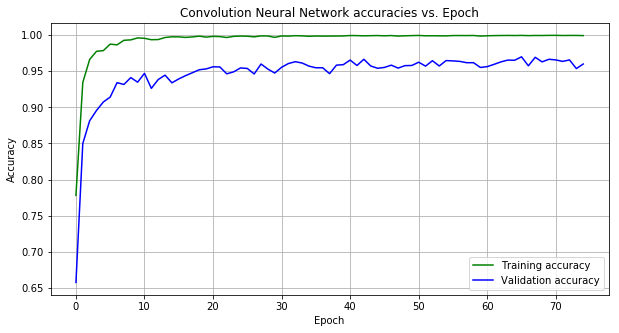

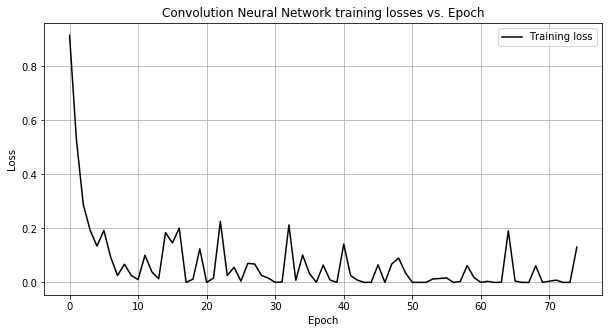

In [29]:
plt.figure(figsize=(10,5))
plt.plot(Epochs,Training_accuracies,'green', label='Training accuracy')
plt.plot(Epochs,Validation_accuracies,'blue', label='Validation accuracy')
plt.title("Convolution Neural Network accuracies vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
         
plt.figure(figsize=(10,5))
plt.plot(Epochs,Training_losses,'black', label='Training loss')
plt.title("Convolution Neural Network training losses vs. Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [30]:
meta_path='./tf-sessions-data/simplecnn_m2_e75_lr100.meta'
data_path='./tf-sessions-data/simplecnn_m2_e75_lr100.data-00000-of-00001'
index_path='./tf-sessions-data/simplecnn_m2_e75_lr100.index'
save_path='./tf-sessions-data/simplecnn_m2_e75_lr100'
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # saver=tf.train.import_meta_graph(meta_path)
    saver.restore(sess,save_path)
    test_accuracy=evaluate(X_test_shuffle,y_test_shuffle)
    
print("No further training or tuning of hyperparameters!")
print("Testing dataset has an accuracy of {} %".format(round(test_accuracy*100),2))

INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100
No further training or tuning of hyperparameters!
Testing dataset has an accuracy of 95.0 %


Confusion matrix plot using Sklearn.metrics

INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


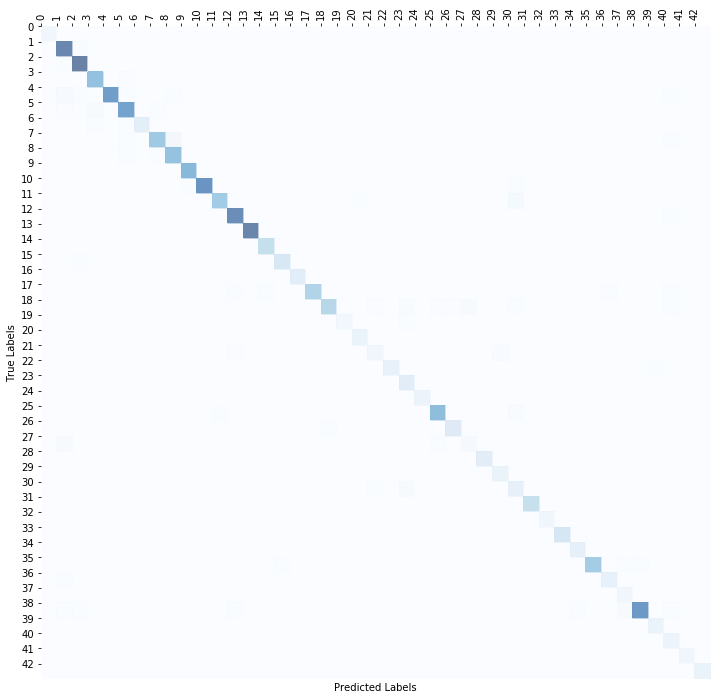

In [31]:
# Confusion Matrix Test Prediction using Sklearn.metrics
print("Confusion matrix plot using Sklearn.metrics\n")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)
    y_test_prediction=sess.run(tf.argmax(logits_cnn,1), feed_dict={X: X_test_shuffle, keep_prob: 1.0})    

confusion_matrix_test=confusion_matrix(y_true=y_test_shuffle,y_pred=y_test_prediction)
fig,ax=plt.subplots()
heatmap=ax.pcolor(confusion_matrix_test, cmap=plt.cm.Blues,alpha=0.6)
fig=plt.gcf()
fig.set_size_inches(12,12)
ax.set_frame_on(False)
ax.invert_yaxis()
ax.xaxis.tick_top()

ticks=np.arange(n_classes)

plt.xticks(ticks,range(n_classes),rotation=90)
plt.yticks(ticks,range(n_classes))

ax.grid(False)

ax = plt.gca()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [32]:
print("Confusion matrix details using pandas\n")
print("Model accuracy of {} on test-image dataset".format(round(test_accuracy,2)))
cm_pandas=ConfusionMatrix_pandas(y_test_shuffle,y_test_prediction).print_stats()

accuracy=streaming_accuracy(predictions=y_test_prediction,labels=y_test_shuffle)

confusion_matrix_model=confusion_matrix_test
for i in range(n_classes):
    true_count=np.sum(y_test_shuffle==i)
    true_prediction=confusion_matrix_test[i,i]
    accuracy=100*true_prediction/true_count
    precision=100*true_prediction/np.sum(confusion_matrix_test[:,i])
    confusion_matrix_model[i,i]=0
    
    misclassified_index=np.argmax(confusion_matrix_model[i,:])

    print("CLASS {}: {}".format(i,arr_classes[i]))
    print("Accuracy: {} %".format(round(accuracy,5)))
    print("Precision: {} %".format(round(precision,5)))
    print("Class has been commonly confused/misclassified as class {}- '{}' with probability {} %"\
          .format(misclassified_index,arr_classes[misclassified_index],round(100*confusion_matrix_test[i,misclassified_index]/true_count,3)))
    print("\n")

Confusion matrix details using pandas

Model accuracy of 0.95 on test-image dataset


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/pandas_ml/confusion_matrix/bcm.py:346: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.LRP) / self.LRN)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/pandas_ml/confusion_matrix/bcm.py:332: RuntimeWarning: divide by zero encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)


Confusion Matrix:

Predicted   0    1    2    3    4    5    6    7    8    9   ...      34   35  \
Actual                                                       ...                
0          59    1    0    0    0    0    0    0    0    0   ...       0    0   
1           1  704   13    0    0    0    0    1    0    0   ...       0    0   
2           0    5  735    1    0    2    0    0    1    0   ...       0    0   
3           0    0    0  434    0   10    0    0    0    0   ...       0    0   
4           1   28    4    0  605    3    0    1    4    2   ...       0    0   
5           2   11   10   18    0  578    1    3    1    0   ...       0    0   
6           0    0    0    6    0    4  137    0    0    0   ...       0    0   
7           0    1    2    2    0    4    0  390   44    2   ...       0    0   
8           1    2    2    2    0    6    0    3  430    2   ...       1    0   
9           0    0    0    0    0    0    0    0    0  480   ...       0    0   
10       

In [33]:
print("Classes 9, 14, 16, 20, 32, 34, 42 have 100 % accuracy and aren't misclassified at all!")

Classes 9, 14, 16, 20, 32, 34, 42 have 100 % accuracy and aren't misclassified at all!


---

## Step 4: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Testing the CNN-model on new images obtained from the Belgian dataset- load & save data. 


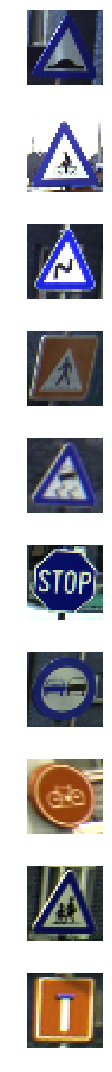

In [34]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
print("Testing the CNN-model on new images obtained from the Belgian dataset- load & save data. ")
verification_folder='traffic-signs-data/Belgian-traffic-signs-data/' 
save_folder='traffic-signs-data/Unseen-images/Belgian/'
valid_choice=[]
chosen_image_Belgian=[]
n_redo=0

if len(os.listdir(save_folder))>1 and n_redo==0:
    items=os.listdir(save_folder)
    images_list=np.zeros((10,32,32,3),dtype=np.uint8)
    
    for name in items:
        if name.endswith(".ppm"):
            valid_choice.append(name)
    for i, item in enumerate(valid_choice):
        image=cv2.resize(cv2.imread(os.path.join(save_folder,item)),(32,32))
        images_list[i]=image
    # Plot, Subplots
    plt.figure(figsize=(15,15))
    for num_images in range(10):
        plt.subplot(10,1,num_images+1)
        plt.tight_layout()
        plt.imshow(images_list[num_images])
        plt.axis('off')
    plt.show()    
    
else:
        
    folder_sample=random.sample(os.listdir(verification_folder),10)
    images_path=[]
    for folder in folder_sample:

        path=os.path.join(verification_folder,folder)
        items=os.listdir(path)

        for name in items:
            if name.endswith(".ppm"):
                valid_choice.append(name)
        image_sample=random.sample(valid_choice,1)

        for i in image_sample:
            image_path=os.path.join(path,i)
            images_path.append(image_path)

    # Splitting functions for readability
    images_list=np.zeros((10,32,32,3),dtype=np.uint8)
    for i,image_index in enumerate(images_path):
        image=cv2.imread(image_index)
        images_list[i]=cv2.resize(image,(32,32))
        chosen_image_Belgian.append(image)

        save_name="Belgian-"+str(i)+".ppm"
        cv2.imwrite(os.path.join(save_folder,save_name),image)

    # Plot, Subplots
    plt.figure(figsize=(12,10))
    for num_images in range(10):
        plt.subplot(10,1,num_images+1)
        plt.tight_layout()
        plt.imshow(images_list[num_images])
        plt.axis('off')
    plt.show()

Testing the CNN-model on new images obtained from Google searches- load & save data.


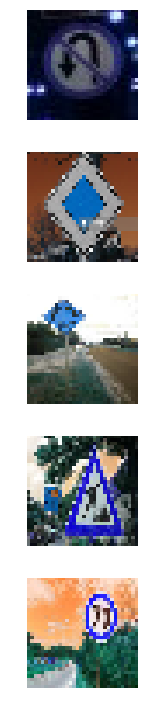

In [35]:
print("Testing the CNN-model on new images obtained from Google searches- load & save data.")
save_folder_net='traffic-signs-data/Unseen-images/Net/'
valid_choice=[]

if len(os.listdir(save_folder_net))>1:
    items=os.listdir(save_folder_net)
    images_list_searched=np.zeros((24,32,32,3),dtype=np.uint8)
    for name in items:
        if name.endswith(".jpg"):
            valid_choice.append(name)
        
    for i, item in enumerate(valid_choice):
        image=cv2.resize(cv2.imread(os.path.join(save_folder_net,item)),(32,32))
        images_list_searched[i]=image
    # Plot, Subplots
    plt.figure(figsize=(12,10))
    for num_images in range(5):
        plt.subplot(5,1,num_images+1)
        plt.tight_layout()
        plt.imshow(images_list_searched[num_images])
        plt.axis('off')
    plt.show()    

### Predict the Sign Type for Each Image

In [36]:
def Model_evaluate(new_images,sess):
    prediction=sess.run(tf.argmax(logits_cnn,1), feed_dict={X: new_images, keep_prob: 1.0})
    top_k=tf.nn.top_k(tf.nn.softmax(logits_cnn),5, sorted=True)
    top_k_pred=sess.run(top_k, feed_dict={X: new_images, keep_prob:1.0})
    return prediction, top_k_pred

#### Using Belgian dataset images

In [37]:
## Preprocessing new images
Belgian_processed_images=[]

for image in images_list:
    Belgian_image_grayscale=(grayscale(image)).reshape(32,32,1)
    Belgian_processed_images.append(normalize(Belgian_image_grayscale))
print("Preprocessing Test images complete")

Preprocessing Test images complete


In [38]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)

    predicted_label_Belgian, top_k_Belgian=Model_evaluate(np.asarray(Belgian_processed_images),sess) 

INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


##### Analyze Performance & Output Softmax Probabilities- Belgian dataset

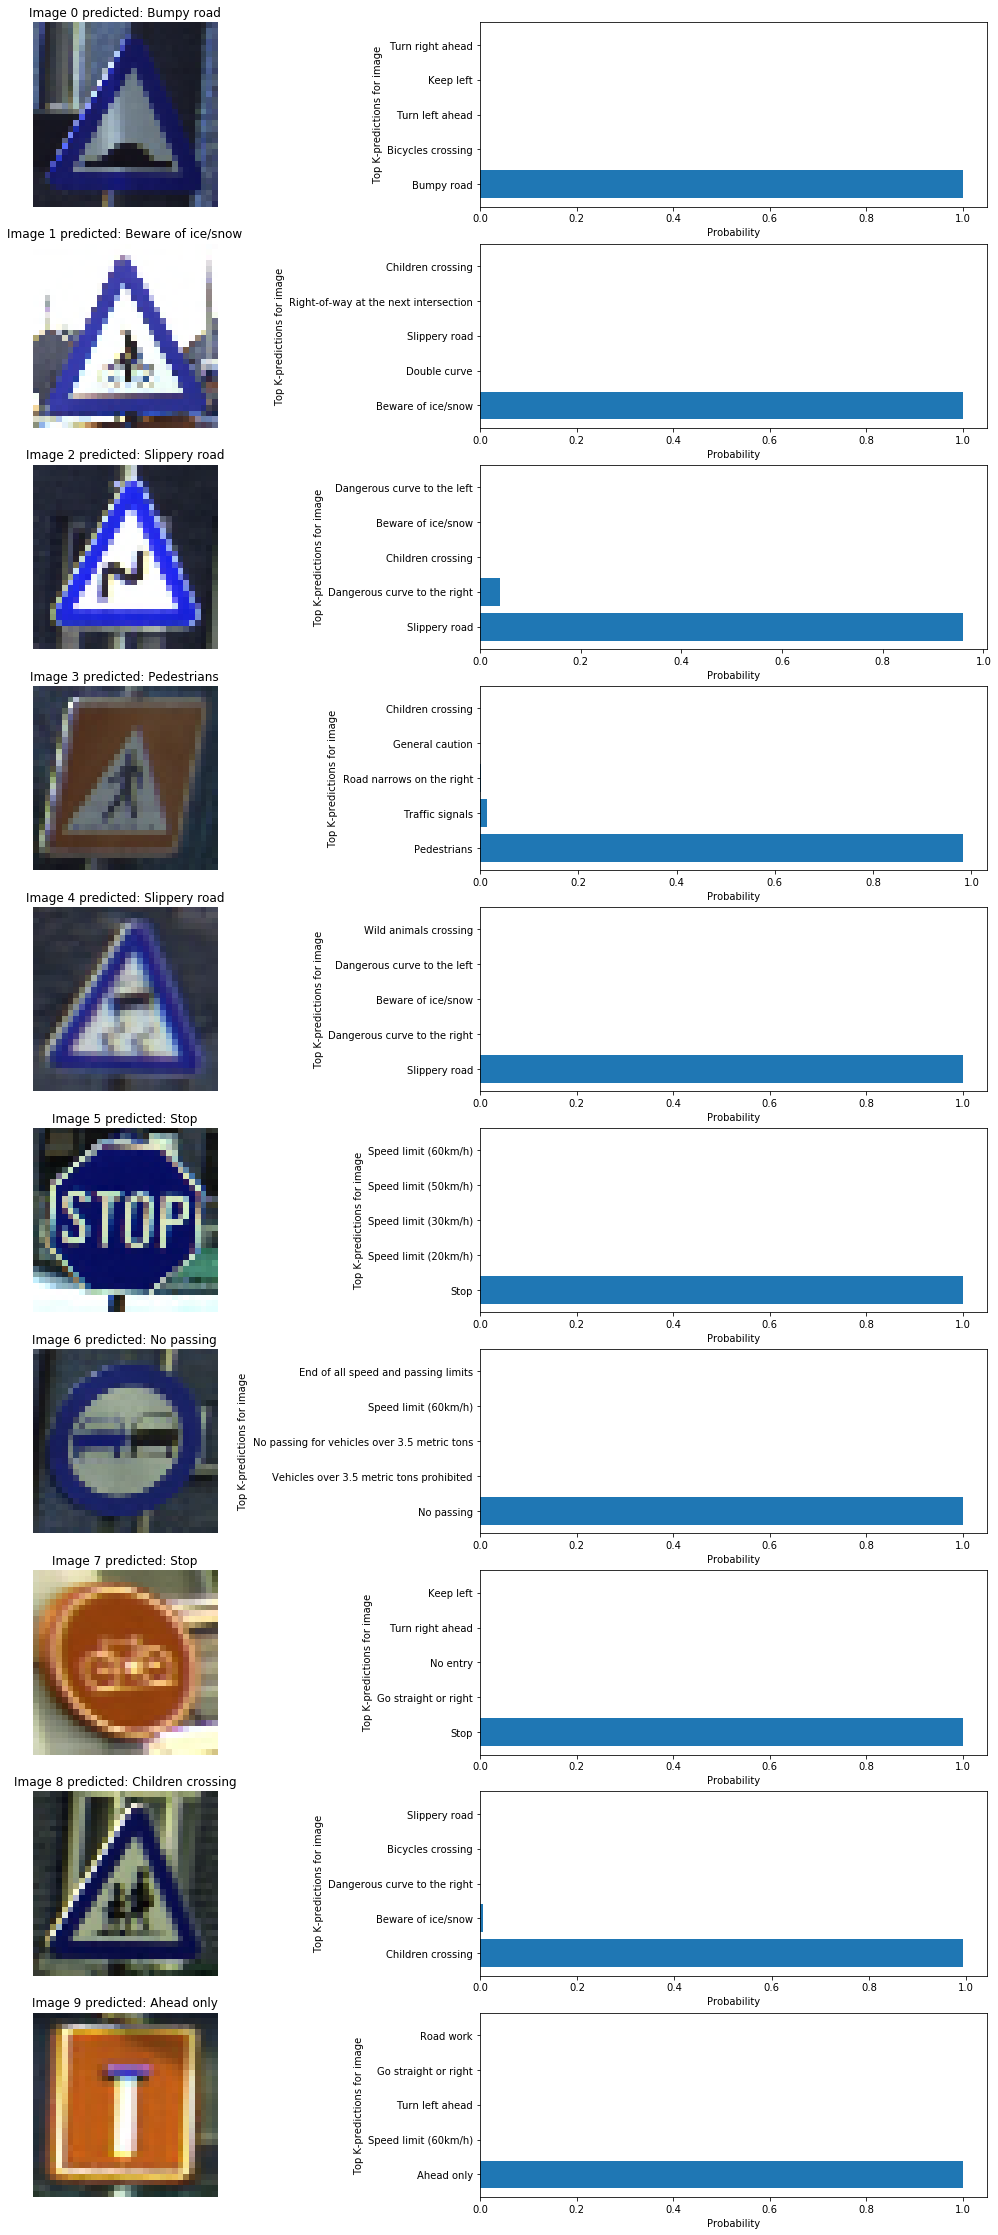

In [39]:
plt.figure(figsize=(20,40))
for i in range(len(Belgian_processed_images)):
    plt.subplot(len(Belgian_processed_images),2,2*i+1)
    plt.imshow(images_list[i])
    plt.axis('off')
    plt.title("Image "+str(i)+" predicted: "+arr_classes[predicted_label_Belgian[i]])
    
    plt.subplot(len(Belgian_processed_images),2,2*i+2)
    plt.barh(np.arange(1,6,1),top_k_Belgian.values[i,:])
    plt.yticks(np.arange(1,6,1),(arr_classes[ind] for ind in top_k_Belgian.indices[i]))
    
    plt.xlabel('Probability')
    plt.ylabel('Top K-predictions for image')
plt.show()    

#### Using images found on the net

In [40]:
## Preprocessing new images
Net_processed_images=[]

for image in images_list_searched:
    Net_image_grayscale=(grayscale(image)).reshape(32,32,1)
    Net_processed_images.append(normalize(Net_image_grayscale))
print("Preprocessing Test images complete")

Preprocessing Test images complete


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide


In [41]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)

    predicted_label_Net, top_k_Net=Model_evaluate(np.asarray(Net_processed_images),sess) 

INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


##### Analyze Performance & Output Softmax Probabilities

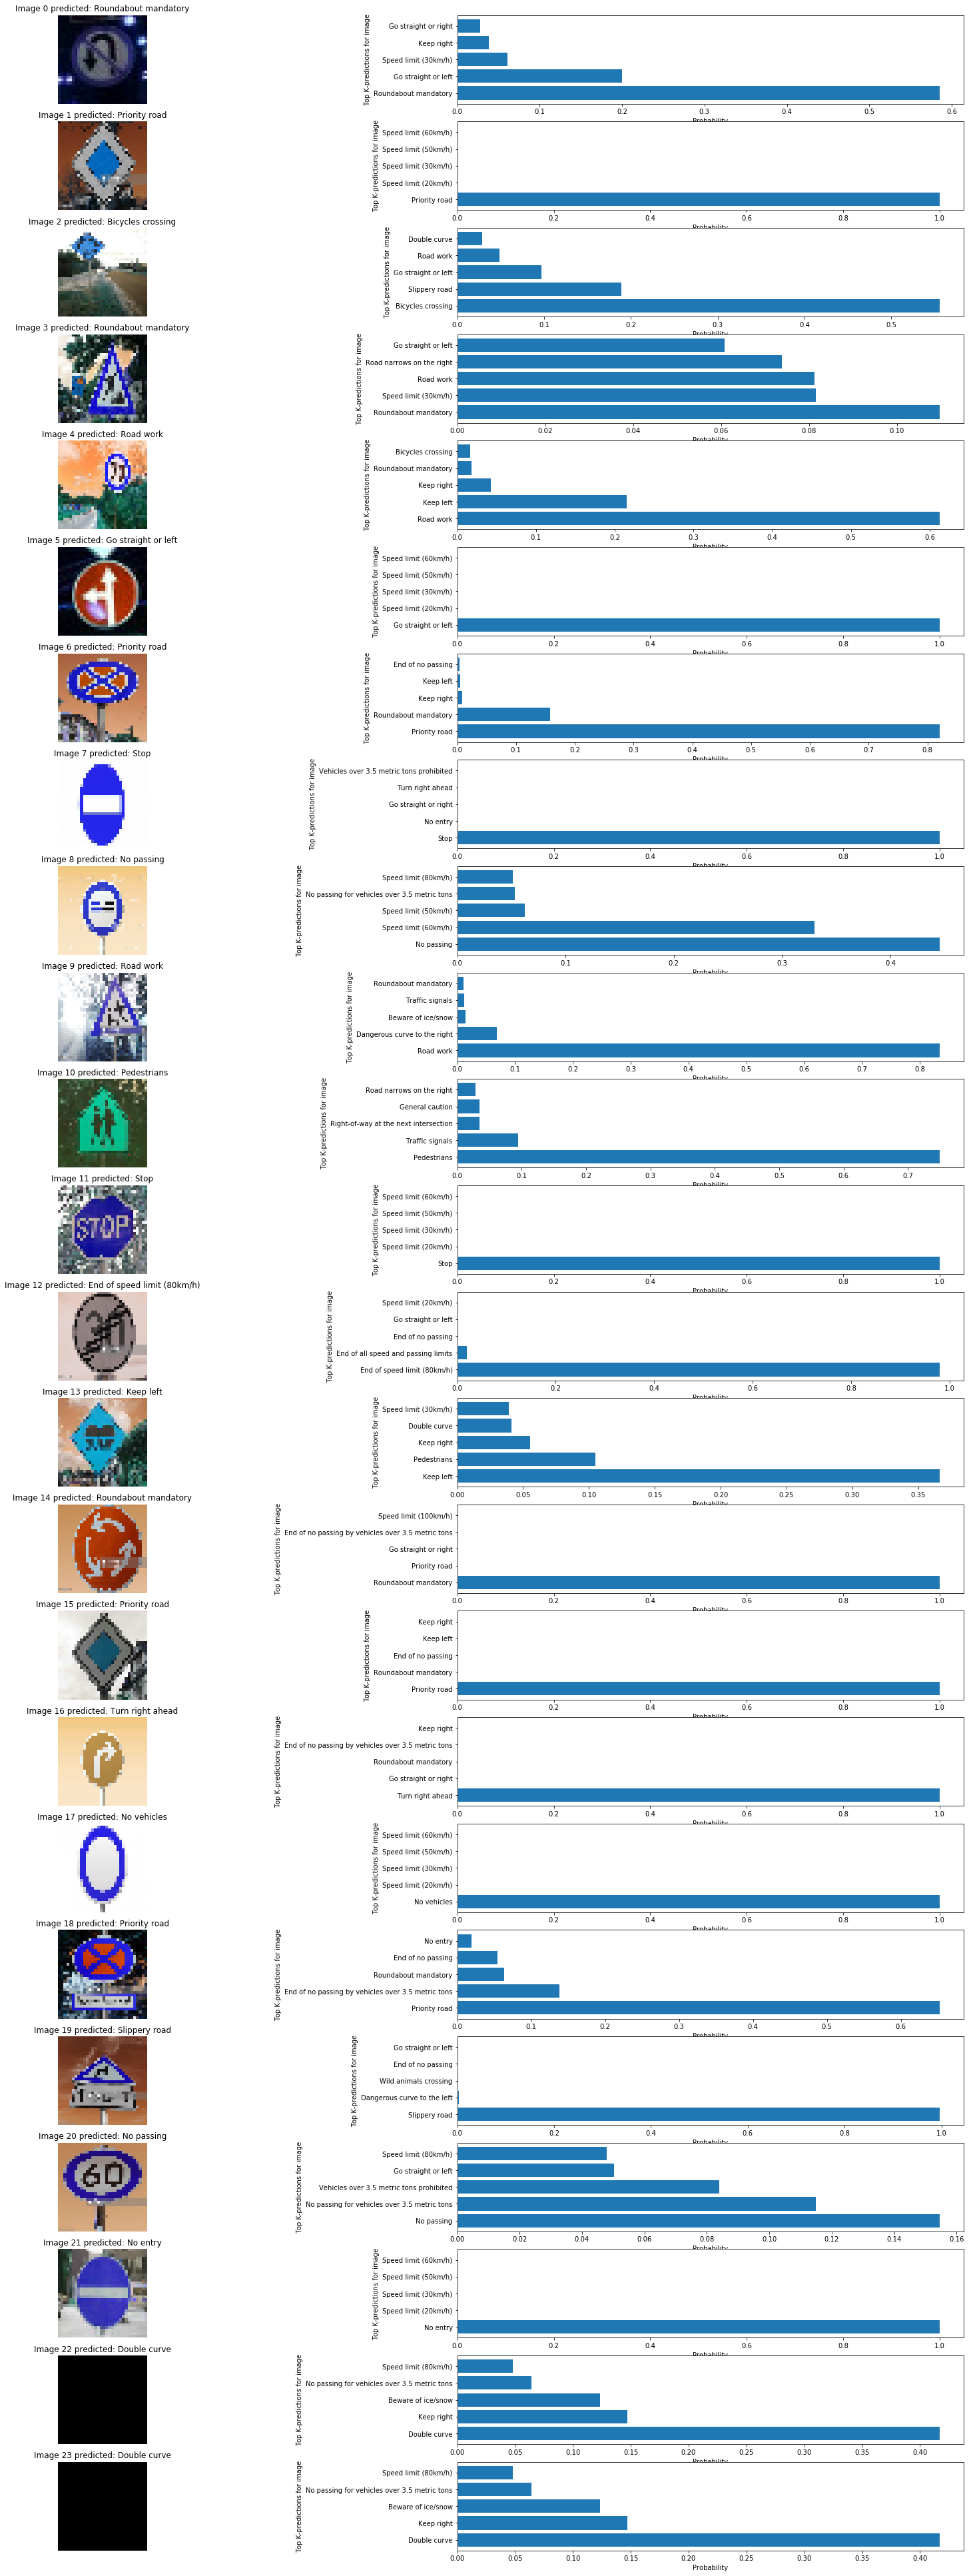

In [42]:
plt.figure(figsize=(30,70))
for i in range(len(Net_processed_images)):
    plt.subplot(len(Net_processed_images),2,2*i+1)
    plt.imshow(images_list_searched[i])
    plt.axis('off')
    plt.title("Image "+str(i)+" predicted: "+arr_classes[predicted_label_Net[i]])
    
    plt.subplot(len(Net_processed_images),2,2*i+2)
    plt.barh(np.arange(1,6,1),top_k_Net.values[i,:])
    plt.yticks(np.arange(1,6,1),(arr_classes[ind] for ind in top_k_Net.indices[i]))
    
    plt.xlabel('Probability')
    plt.ylabel('Top K-predictions for image')
plt.show()    

---

## Step 5 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [43]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={X : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [44]:
# Another method to visualize activations
def Plot_activations(activations):
    filters=activations.shape[3]
    plt.figure(1,figsize=(12,12))
    cols=5
    rows=math.ceil(filters/cols)+1
    for i in range(filters):
        plt.subplot(rows,cols,i+1)
        plt.title('Filter'+str(i))
        plt.imshow(activations[0,:,:,i], interpolation='nearest', cmap='gray')
    
def Obtain_activations(layer,sample_image):
    activations=sess.run(layer,feed_dict={X:np.reshape(sample_image,[1,32,32,1]), keep_prob:1.0})
    Plot_activations(activations)

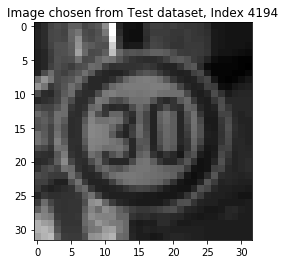

In [45]:
# Selecting a random image from the validation dataset.
rand_index=random.randint(0,len(X_valid_shuffle))
selected_image=X_valid_shuffle[rand_index].reshape(1,32,32,1)

plt.title('Image chosen from Test dataset, Index {}'.format(rand_index))
plt.imshow(selected_image.reshape(32,32), cmap='gray')
plt.show()

In [46]:
# Listing paths in the graph
save_path='./tf-sessions-data/simplecnn_m2_e75_lr100'

activation_1="EntropyCost/Convolution_Layer_1/activation_1:0"
activation_2="EntropyCost/Convolution_Layer_2/activation_2:0"
activation_3="EntropyCost/Convolution_Layer_3/activation_3:0"
activation_4="EntropyCost/Dense_Layer_1/activation_4:0"
activation_5="EntropyCost/Dense_Layer_2/activation_5:0"
activation_6="EntropyCost/Dense_Layer_3/activation_6:0"

Layer One Activation
INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


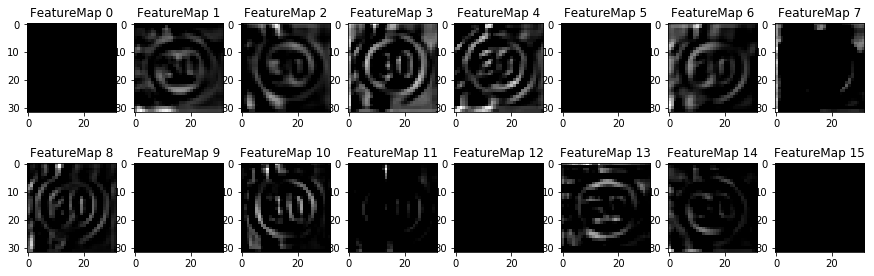

In [47]:
print("Layer One Activation")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess,save_path)
       
    act1=tf.get_default_graph().get_tensor_by_name(activation_1)
    outputFeatureMap(selected_image,act1)

Obtain Activations Layer One
INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


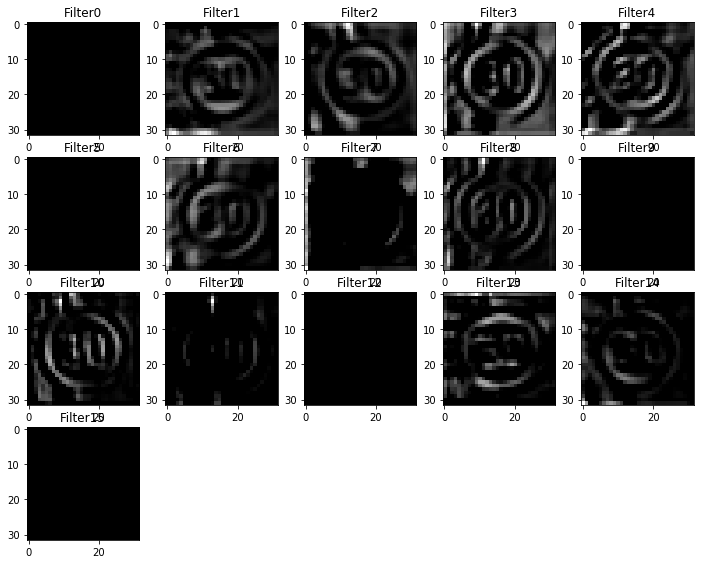

In [48]:
print("Obtain Activations Layer One")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess,save_path)
    Obtain_activations(activation_1,selected_image)

Obtain Activations Layer Two
INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


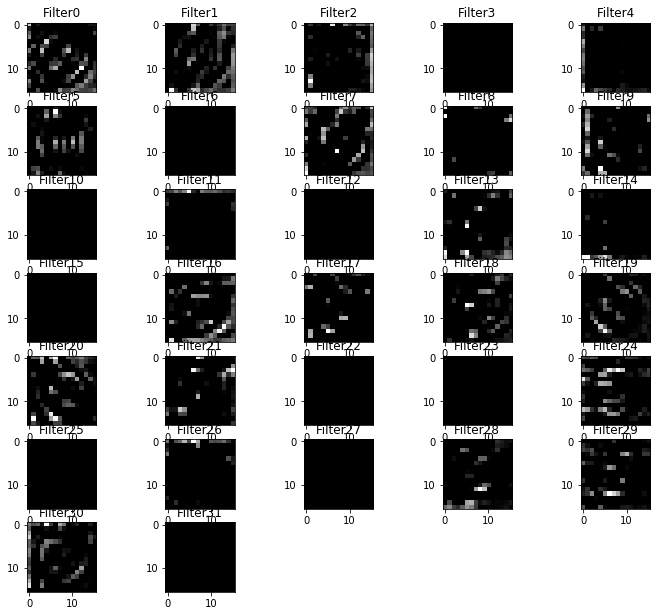

In [49]:
print("Obtain Activations Layer Two")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess,save_path)
    Obtain_activations(activation_2,selected_image)

Obtain Activations Layer Three
INFO:tensorflow:Restoring parameters from ./tf-sessions-data/simplecnn_m2_e75_lr100


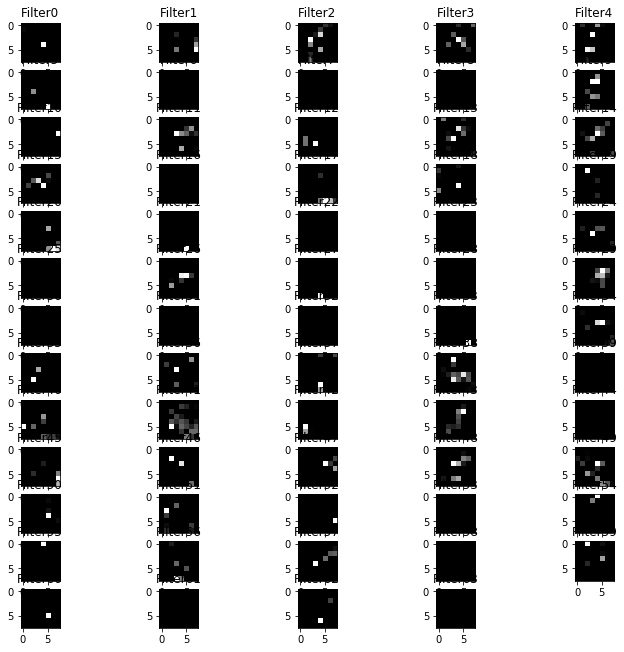

In [50]:
print("Obtain Activations Layer Three")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    saver.restore(sess,save_path)
    Obtain_activations(activation_3,selected_image)

In [54]:
sess.close()

In [55]:
print("Script terminated at",str(datetime.now()))

Script terminated at 2017-08-24 06:57:44.778740
